In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 4. CNN *vs* RNN Prediciendo el Ozono Atmosférico

**a)**

In [2]:
data = pd.read_csv('./ozone_data.csv') 
data_train, data_val, data_test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

In [3]:
data_train_o3= data_train[["registered_on","O3"]].sort_index()
data_val_o3= data_val[["registered_on", "O3"]].sort_index()
data_test_o3= data_test[["registered_on","O3"]].sort_index()

In [4]:
X_train = data_train.values[:,1:]
X_test = data_test_o3.values[:,1:]
X_val = data_val_o3.values[:,1:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_val)
X_val_scaled = scaler.transform(X_val)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

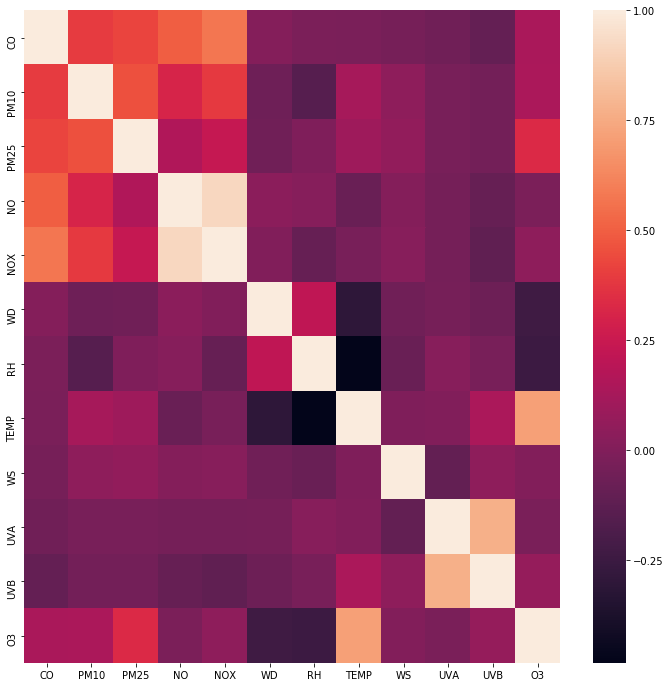

In [5]:
plt.subplots(figsize = (12,12))
sn.heatmap(data.corr())

**b)**

In [6]:
def create_dataset(dataset,lag=1):
    dataX = []
    dataY = []
    dataset = dataset.flatten()
    for i in range(lag+1, len(dataset)):
        dataX.append(dataset[i-(lag+1):i-1])
        dataY.append(dataset[i])
    return np.array(dataX),np.array(dataY)

In [7]:
lag = 3
trainX, trainY = create_dataset(X_train_scaled, lag)
testX, testY = create_dataset(X_test_scaled, lag)
valX, valY = create_dataset(X_val_scaled, lag)

**c)**

In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

In [9]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=4, input_shape=(1,lag), activation='tanh',return_sequences=False,go_backwards=False))
model_rnn.add(Dense(1,activation='linear'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.summary()
rnn_weights = model_rnn.get_weights()
hist_rnn = model_rnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
11720/11720 [==============================] - 17s 1ms/step - loss: 0.9946
Epoch 2/25
11720/11720 [==============================] - 16s 1ms/step - loss: 0.9824
Epoch 3/25
11720/11720 [==============================] - 16s 1ms/step - loss: 0.9799
Epoch 4/25
11720/11720 [==============================] - 17s 1ms/step - loss: 0.9789
Epoch 5/25
11720/11720 [==============================] - 18s 2ms/step - loss:

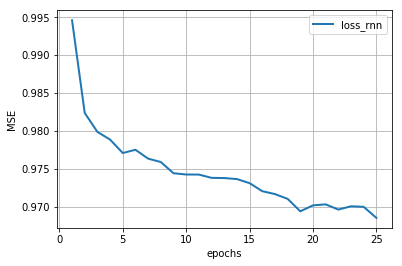

In [10]:
listaloss_rnn  = []
for i in range(25):
    listaloss_rnn.append(hist_rnn.history['loss'][i])

plt.plot(range(26)[1:],listaloss_rnn,label='loss', linewidth=2)

plt.legend(['loss_rnn'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

In [25]:
model_cnn = Sequential()
model_cnn.add(Conv1D(4, kernel_size=1,input_shape=(1,lag), activation='relu',padding='valid')) 
model_cnn.add(Flatten())
model_cnn.add(Dense(1,activation='linear'))
model_cnn.compile(loss='mean_squared_error', optimizer='adam')
model_cnn.summary()
cnn_weights = model_cnn.get_weights()
hist_cnn = model_cnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 4)              16        
_________________________________________________________________
flatten_2 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
11720/11720 [==============================] - 13s 1ms/step - loss: 0.9884
Epoch 2/25
11720/11720 [==============================] - 13s 1ms/step - loss: 0.9837
Epoch 3/25
11720/11720 [==============================] - 12s 1ms/step - loss: 0.9845
Epoch 4/25
11720/11720 [==============================] - 12s 1ms/step - loss: 0.9830
Epoch 5/25
11720/11720 [==============================] - 12s 1ms/

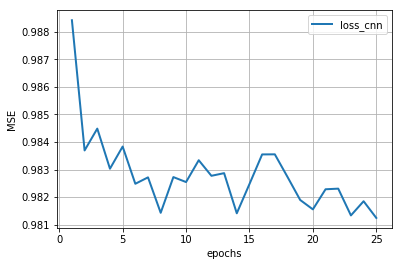

In [26]:
listaloss_cnn  = []
for i in range(25):
    listaloss_cnn.append(hist_cnn.history['loss'][i])

plt.plot(range(26)[1:],listaloss_cnn,label='loss', linewidth=2)

plt.legend(['loss_cnn'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

comente sobre las dimensiones/shape de los parámetros de cada una de las redes. Entrene los dos modelos con la nueva representación ¿Qué limitaciones tiene el tamaño/width del kernel de la convolucional?.

**d)**

In [12]:
trainPredict_rnn = model_rnn.predict(trainX,batch_size=1)
trainPredict_rnn = scaler.inverse_transform(trainPredict_rnn)

trainY_rnn = scaler.inverse_transform(trainY)

testPredict_rnn = model_rnn.predict(testX,batch_size=1)
testPredict_rnn = scaler.inverse_transform(testPredict_rnn)

testY_rnn = scaler.inverse_transform(testY)

In [13]:
trainScore_rnn = np.sqrt(mean_squared_error(trainY_rnn, trainPredict_rnn))
print('Train Score: %.2f RMSE' % (trainScore_rnn))
testScore_rnn = np.sqrt(mean_squared_error(testY_rnn, testPredict_rnn))
print('Test Score: %.2f RMSE' % (testScore_rnn))

Train Score: 0.13 RMSE
Test Score: 0.13 RMSE


In [29]:
trainPredict_cnn = model_cnn.predict(trainX,batch_size=1)
trainPredict_cnn = scaler.inverse_transform(trainPredict_cnn)

trainY_cnn = scaler.inverse_transform(trainY)

testPredict_cnn = model_cnn.predict(testX,batch_size=1)
testPredict_cnn = scaler.inverse_transform(testPredict_cnn)

testY_cnn = scaler.inverse_transform(testY)

In [30]:
trainScore_cnn = np.sqrt(mean_squared_error(trainY_cnn, trainPredict_cnn))
print('Train Score: %.2f RMSE' % (trainScore_cnn))
testScore_cnn = np.sqrt(mean_squared_error(testY_cnn, testPredict_cnn))
print('Test Score: %.2f RMSE' % (testScore_cnn))

Train Score: 0.13 RMSE
Test Score: 0.13 RMSE


**e)**

Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción del modelo, comente.

#### RNN

**Entrenamiento**

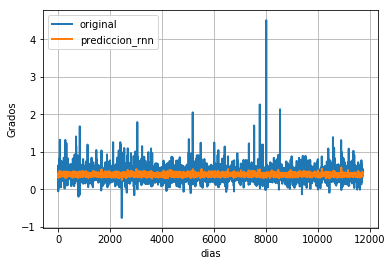

In [50]:
trainY_rnn = np.reshape(trainY_rnn, (trainY_rnn.shape[0], 1))
plt.plot(range(len(trainY_rnn)),trainY_rnn[:,0],label='original', linewidth=2)
plt.plot(range(len(trainY_rnn)),trainPredict_rnn[:,0],label='prediccion_rnn', linewidth=2)

plt.legend(['original','prediccion_rnn'])
plt.ylabel('Grados')
plt.xlabel('dias')
plt.grid(1)
plt.show()

**Prueba**

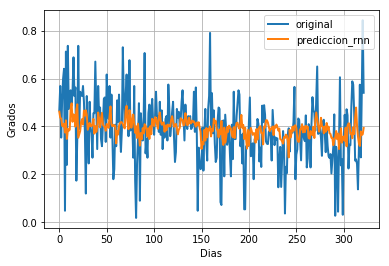

In [51]:
testY_rnn = np.reshape(testY_rnn, (testY_rnn.shape[0], 1))
plt.plot(range(len(testY_rnn)),testY_rnn[:,0],label='original', linewidth=2)
plt.plot(range(len(testY_rnn)),testPredict_rnn[:,0],label='prediccion_rnn', linewidth=2)

plt.legend(['original','prediccion_rnn'])
plt.ylabel('Grados')
plt.xlabel('Dias')
plt.grid(1)
plt.show()

#### CNN
**Entrenamiento**

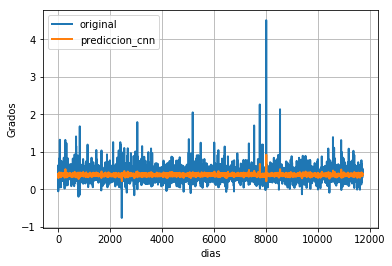

In [52]:
trainY_cnn = np.reshape(trainY_cnn, (trainY_cnn.shape[0], 1))
plt.plot(range(len(trainY_cnn)),trainY_cnn[:,0],label='original', linewidth=2)
plt.plot(range(len(trainY_cnn)),trainPredict_cnn[:,0],label='prediccion_cnn', linewidth=2)

plt.legend(['original','prediccion_cnn'])
plt.ylabel('Grados')
plt.xlabel('dias')
plt.grid(1)
plt.show()

**Prueba**

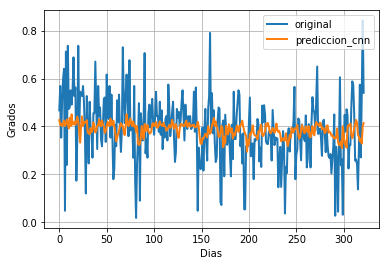

In [53]:
testY_cnn = np.reshape(testY_cnn, (testY_cnn.shape[0], 1))
plt.plot(range(len(testY_cnn)),testY_cnn[:,0],label='original', linewidth=2)
plt.plot(range(len(testY_cnn)),testPredict_cnn[:,0],label='prediccion_cnn', linewidth=2)

plt.legend(['original','prediccion_cnn'])
plt.ylabel('Grados')
plt.xlabel('Dias')
plt.grid(1)
plt.show()

Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción del modelo, comente.

**f)**
> f) En lugar de aumentar el número de dimensiones como el el paso c), entrene la red con un *timestep=lag* y con dimensión de entrada = 1. Compare y comente sobre el cambio de dimensiones y número de parámetros de las redes ¿Cuál tipo de red tiene más parámetros y porqué? ¿Se produce una mejora del error de entrenamiento y pruebas? ¿Los tiempos de computación son comparables? Comente brevemente sobre cuál es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e).
```python
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=4, input_shape=(lag,1), activation='tanh',return_sequences=False,go_backwards=False))
model_rnn.add(Dense(1,activation='linear'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
model_rnn.summary()
... #and now CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(4, kernel_size=3,input_shape=(lag,1), activation='relu',padding='valid')) # or kernel=2
model_cnn.add(Flatten())
model_cnn.add(Dense(1,activation='linear'))
model_cnn.summary()

In [49]:
monitor = EarlyStopping(monitor = 'loss',min_delta=1e-6,patience=5,verbose=1,mode='auto')
lag = 3
trainX, trainY = timeseries_to_supervised(stream_train_scaled, lag)
testX, testY = timeseries_to_supervised(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

model = Sequential()
model.add(LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid"))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(trainX, trainY,callbacks=[monitor], epochs=25, batch_size=1, verbose=1)

plt.plot(range(len(hist.history['loss'])+1)[1:],hist.history['loss'],label='loss', linewidth=2)

plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

NameError: name 'EarlyStopping' is not defined

**g)** 
> g) Compare el desempeño de ambos modelos al variar el *lag* definido en c), recuerde que puede variarlo entre 1 y $T_{max}$. Comente brevemente sobre qué resulta mejor, el tener más información para predecir o si ésto satura la predicción por el efecto del gradiente desvaneciente ¿Ésto ocurre sólo con el modelo recurrente o con el convolucional también? ¿Por qué?

**h)**
> h) Como habrá notado, si usa una ventana de tiempo/*timesteps* muy larga ($T$ grande), las redes tienen dificultades para aprender. Para abordar este problema se le pide experimentar con la siguiente idea: dividir una secuencia de largo $T$ en trozos de largo $K$ y representarla como una matriz de $T/K$ columnas (asumamos que $T$ es un múltiplo de $K$) y $K$ filas, y entrenar la red para procesar la secuencia formada las columnas de esa matriz. De este modo, la red debe aprender dependencias temporales más cortas (largo $T/K$ en vez de $T$), pero accede a toda la información original en forma de atributos ($K$). Llamaremos a esta idea “**time folding**”. Se le recomienda usar un valor de $K$ que tenga sentido en el problema (por ejemplo $K=7$ representaría una semana). Defina y entrene los modelos para ésta nueva representación.  
¿Cómo se ven afectados los modelos?
```python
model_rnn = ?
model_cnn = ?

**k)**

#### Agregar otras mediciones como input:  $CO, PM10, NO, NO_x,...,UVB, O_3$



<img src="https://image.slidesharecdn.com/scaled-ml-2018-180529212354/95/role-of-tensors-in-machine-learning-2-638.jpg?cb=1527629345" title="tensors" width="65%"/>

*Decida si continuar con la convolucional 1D o cambiar a convolucional 2D, comente sobre ésta decisión.*

> k) Agregue las otras mediciones como nuevos valores de entrada al modelo definido en f), por lo que ahora se transforma la serie de tiempo a N-Dimensional, se tiene un *timestep=lag* con un *features*= mediciones nuevas + Ozono. Defina los nuevos modelos con el mejor *lag* encontrado en g).
```python
...#ejemplo:
new_sequences = np.vstack([co_seq,pm10_seq,...,O3_seq]) # (Contaminantes, dias de verano entre 2003-2016)
```


**i)**
> l) Entrene los modelos  ¿Se observan los mismos resultados? ¿Las mediciones incorporadas como información adicional ayudan al modelo? Comente y compare.